## Klasyfikacja ręcznie pisanych liczb - MNIST

Po wykonaniu poprzedniego zadania zleceniodawca znów zadzwonił do Ciebie z kolejnym zadaniem. Okazuje się, że nie wszystkie informacje trafiły do zbioru Tytanic. Brakowało w nim między innymi informacji o pokojach w których mieszkali pasażerowie. Wszystkie informacje o miejscu spania były bowiem zapisane odręcznie na kartkach. Tajemniczy  więc zlecił Ci nowe zadanie... **Stworzenie konwolucyjnej sieci neuronowej rozpoznającej ręcznie pisane cyfry.**

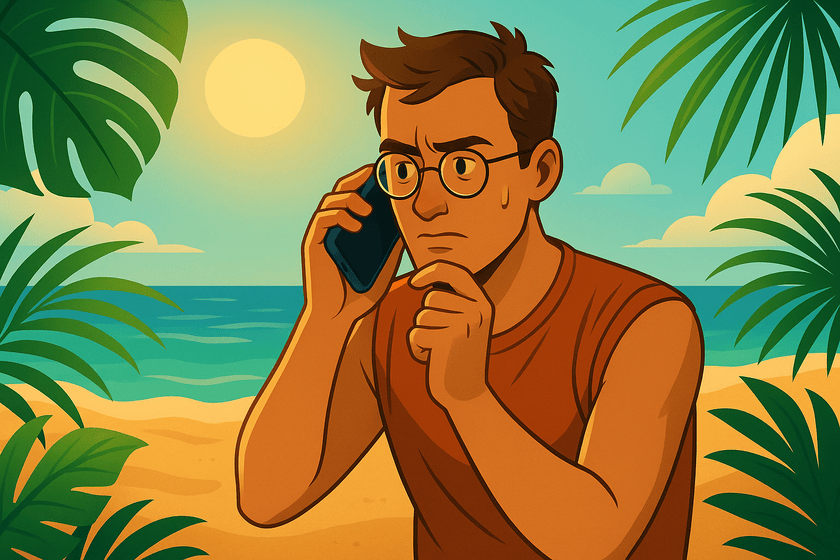

(*AI-generated image*)


#### Twoim celem będzie jest wytrenowanie modelu widzenia komputerowego (CNN) do klasyfikacji każdej ręcznie pisanej liczby z jak najlepszą dokładnością.

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:

- Co mój model robi i w jaki sposób?
- Na czym skupia się mój model?
- Jakie liczby mój model myli? Dlaczego?
- Jak uodpornić mój model?
- Jaki wynik klasyfikacji możemy uznać za *dobry*?


Wymagania:
- Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?
- Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie zwykła sieć (nie musi być na wszystkich próbkach - zajmie to długo)
- W badaniach użyj wybranych metryk. Wybór uzasadnij.
- Spróbuj dobrać strukture sieci (szerokość i wysokość) i sprawdź jaki ma wpływ na dokładność
- Ćwiczenie: zmień liczbę kanałów/warstw, dodaj BatchNorm, spróbuj zwiększyć/zmniejszyć dropout.
- Wypisz wnioski.
- Korzystaj z `PyTorch` (`torch, torchvision`)

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

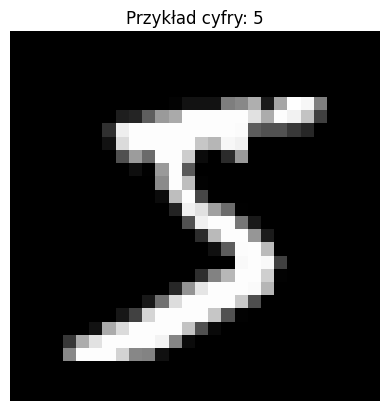

In [9]:
# ładowanie zbioru danych
import tensorflow as tf
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


plt.imshow(x_train[0], cmap='gray')
plt.title(f"Przykład cyfry: {y_train[0]}")
plt.axis('off')
plt.show()

1. Dane

In [10]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [11]:
import numpy as np
print(np.max(x_train))
print(np.min(x_train))

255
0


In [12]:

# Normalizujemy dane do zakresu 0-1, piksele maja wartosci od 0 do 255
x_train = x_train / 255
x_test = x_test / 255

In [17]:
# Konwersja danych do tensorów PyTorch
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).long()
x_test_tensor = torch.from_numpy(x_test).float()
y_test_tensor = torch.from_numpy(y_test).long()

# Tworzenie niestandardowego zbioru danych PyTorch
class MNISTDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# Tworzenie instancji zbiorów danych
full_train_ds = MNISTDataset(x_train_tensor, y_train_tensor)
test_ds = MNISTDataset(x_test_tensor, y_test_tensor)

# Podział zbioru treningowego na treningowy i walidacyjny
train_size = int(0.8 * len(full_train_ds))
val_size = len(full_train_ds) - train_size
train_ds, val_ds = random_split(full_train_ds, [train_size, val_size])

In [21]:
BATCH_SIZE = 128
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

2. Baseline

Stworzymy prosty nn z 2 warstwami

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np

# Definicja prostej sieci neuronowej
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Hiperparametry
input_size = 28 * 28
hidden_size = 128
num_classes = 10
num_epochs = 5
learning_rate = 0.001

# Inicjalizacja modelu
model = SimpleNN(input_size, hidden_size, num_classes)

# Funkcja straty i optymalizator
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Płaska struktura danych wejściowych dla prostej sieci neuronowej
def flatten_images(images):
    return images.view(-1, input_size)

# Trening modelu
print("Starting training...")
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Przekształcenie obrazów do płaskiej struktury
        images = flatten_images(images)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

print("Training finished.")

# Ewaluacja modelu na zbiorze testowym
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = flatten_images(images)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')

Starting training...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch [1/5], Step [100/375], Loss: 0.4217
Epoch [1/5], Step [200/375], Loss: 0.2825
Epoch [1/5], Step [300/375], Loss: 0.2575
Epoch [2/5], Step [100/375], Loss: 0.2339
Epoch [2/5], Step [200/375], Loss: 0.2953
Epoch [2/5], Step [300/375], Loss: 0.1274
Epoch [3/5], Step [100/375], Loss: 0.1544
Epoch [3/5], Step [200/375], Loss: 0.2023
Epoch [3/5], Step [300/375], Loss: 0.1486
Epoch [4/5], Step [100/375], Loss: 0.1259
Epoch [4/5], Step [200/375], Loss: 0.0751
Epoch [4/5], Step [300/375], Loss: 0.1236
Epoch [5/5], Step [100/375], Loss: 0.2120
Epoch [5/5], Step [200/375], Loss: 0.0323
Epoch [5/5], Step [300/375], Loss: 0.1419
Training finished.
Accuracy of the network on the 10000 test images: 96.69%


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


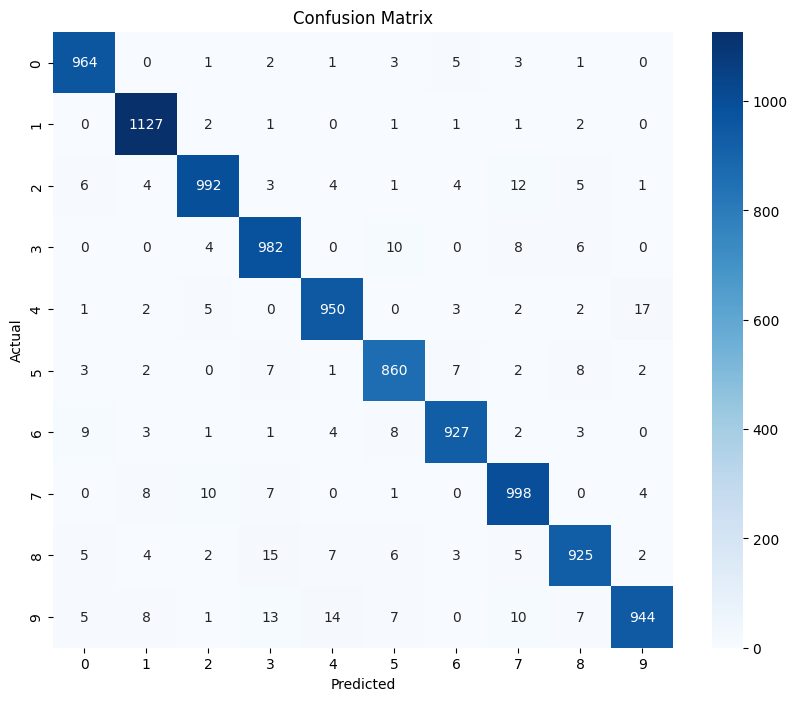

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions for the test set
all_predicted = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = flatten_images(images) # Flatten the images for the simple NN
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_predicted)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Ta sieć ma aż 96,7% dokładności. W naszej docelowej będziemy celować w prawie 100%

In [24]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)  # 1 kanał, 32 filtry 3x3
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return nn.functional.log_softmax(x, dim=1)

model = CNNModel()

Zdecydowałem się na 2 warstwy konwolucyjne. Wprowadziłem dropout 2d, który dropuje całe filtry, żeby bardziejj uodpornić model na przeuczenie. jako funkcje aktywacji standardowo wziąłem relu. Przejdźmy teraz do treningu

In [25]:
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the CNN model
print("Starting CNN training...")
num_epochs_cnn = 10 # You can adjust this number
for epoch in range(num_epochs_cnn):
    model.train() # Set the model to training mode
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        # Add a channel dimension for CNN input (batch_size, 1, height, width)
        images = images.unsqueeze(1)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs_cnn}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}')
            running_loss = 0.0

print("CNN training finished.")

# Evaluating the CNN model
print("Evaluating CNN model...")
model.eval() # Set the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        # Add a channel dimension for CNN input
        images = images.unsqueeze(1)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the CNN network on the 10000 test images: {100 * correct / total}%')

Starting CNN training...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch [1/10], Step [100/375], Loss: 0.6566
Epoch [1/10], Step [200/375], Loss: 0.2584
Epoch [1/10], Step [300/375], Loss: 0.1799
Epoch [2/10], Step [100/375], Loss: 0.1244
Epoch [2/10], Step [200/375], Loss: 0.1149
Epoch [2/10], Step [300/375], Loss: 0.1154
Epoch [3/10], Step [100/375], Loss: 0.0883
Epoch [3/10], Step [200/375], Loss: 0.0903
Epoch [3/10], Step [300/375], Loss: 0.0746
Epoch [4/10], Step [100/375], Loss: 0.0680
Epoch [4/10], Step [200/375], Loss: 0.0713
Epoch [4/10], Step [300/375], Loss: 0.0710
Epoch [5/10], Step [100/375], Loss: 0.0560
Epoch [5/10], Step [200/375], Loss: 0.0513
Epoch [5/10], Step [300/375], Loss: 0.0609
Epoch [6/10], Step [100/375], Loss: 0.0509
Epoch [6/10], Step [200/375], Loss: 0.0525
Epoch [6/10], Step [300/375], Loss: 0.0492
Epoch [7/10], Step [100/375], Loss: 0.0441
Epoch [7/10], Step [200/375], Loss: 0.0488
Epoch [7/10], Step [300/375], Loss: 0.0456
Epoch [8/10], Step [100/375], Loss: 0.0471
Epoch [8/10], Step [200/375], Loss: 0.0376
Epoch [8/10

Mamy 98,98%, zobaczmy jeszcze pozostałe metryki

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


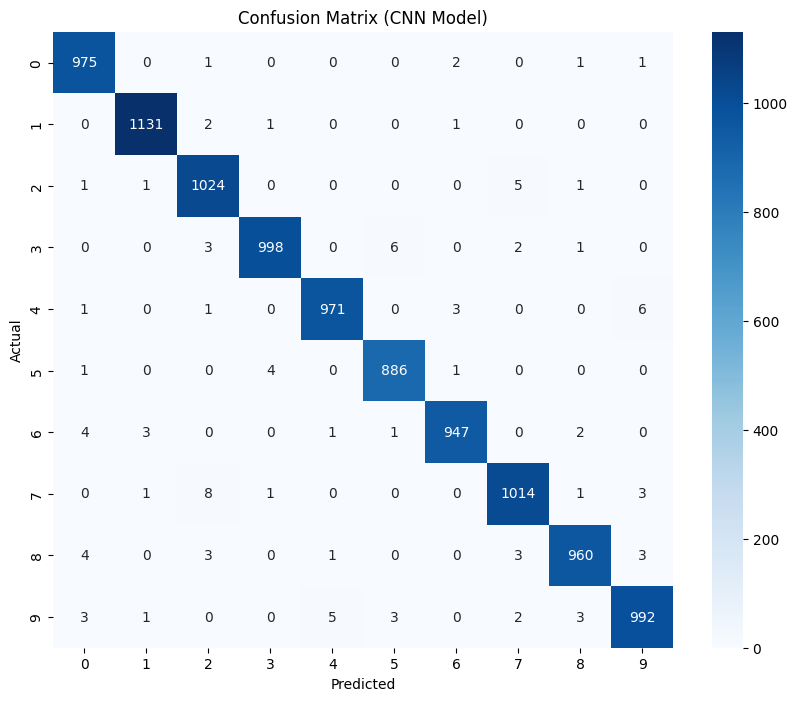


Classification Report (CNN Model):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.98      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get predictions for the test set
all_predicted = []
all_labels = []
model.eval() # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in test_loader:
        # Add a channel dimension for CNN input (batch_size, 1, height, width)
        images = images.unsqueeze(1)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_predicted)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (CNN Model)')
plt.show()

# Display classification report
print("\nClassification Report (CNN Model):")
print(classification_report(all_labels, all_predicted))

Zobaczmy jeszcze przykłady danych źle zkategoryzowanych

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Found 102 misclassified images.


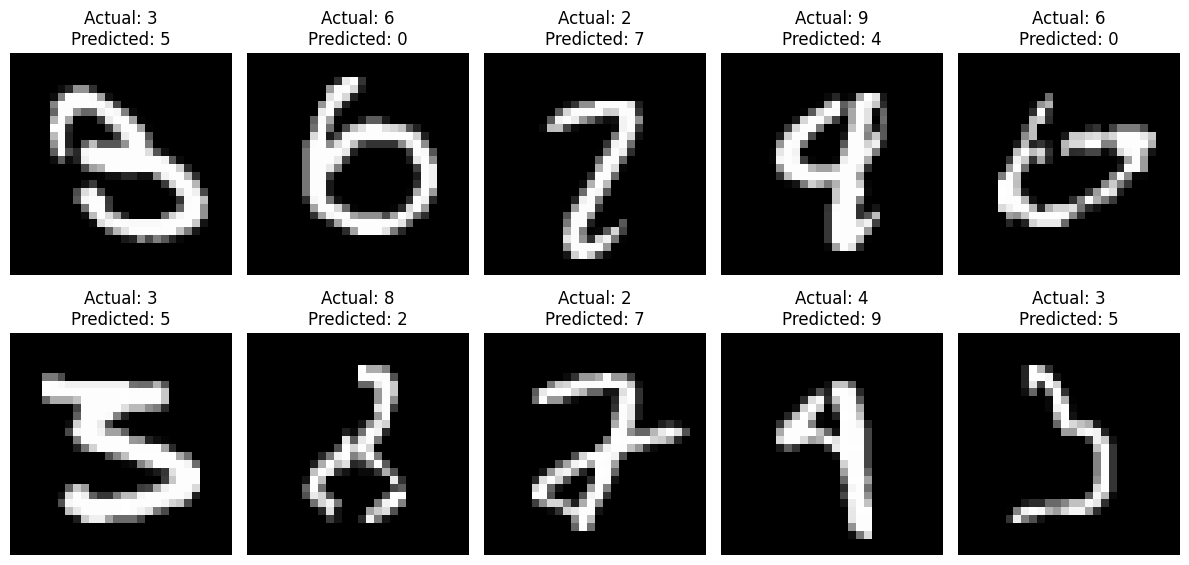

In [27]:
# Identify misclassified images
misclassified_images = []
misclassified_labels = []
misclassified_predictions = []

model.eval() # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in test_loader:
        # Add a channel dimension for CNN input
        images = images.unsqueeze(1)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        # Find misclassified examples in the current batch
        incorrect_indices = (predicted != labels).nonzero(as_tuple=True)[0]

        # Append misclassified images, labels, and predictions
        misclassified_images.extend(images[incorrect_indices].squeeze(1).cpu().numpy())
        misclassified_labels.extend(labels[incorrect_indices].cpu().numpy())
        misclassified_predictions.extend(predicted[incorrect_indices].cpu().numpy())

print(f"Found {len(misclassified_images)} misclassified images.")

# Plot some of the misclassified images
num_images_to_plot = 10 # You can adjust this number
plt.figure(figsize=(12, 6))
for i in range(min(num_images_to_plot, len(misclassified_images))):
    plt.subplot(2, 5, i + 1)
    plt.imshow(misclassified_images[i], cmap='gray', interpolation='none')
    plt.title(f"Actual: {misclassified_labels[i]}\nPredicted: {misclassified_predictions[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

Z niektórymi sam miałbym problem :) Ale może uda się jeszcze bardziej ulepszyć model. Funkcja straty cały czas spadała więc może spróbujemy więcej epok.

In [28]:
# Training the CNN model
print("Starting CNN training...")
num_epochs_cnn = 15 # You can adjust this number
for epoch in range(num_epochs_cnn):
    model.train() # Set the model to training mode
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        # Add a channel dimension for CNN input (batch_size, 1, height, width)
        images = images.unsqueeze(1)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs_cnn}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}')
            running_loss = 0.0

    # Evaluate on validation set after each epoch
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    print(f'Epoch [{epoch+1}/{num_epochs_cnn}], Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')


print("CNN training finished.")

# Evaluating the CNN model on the test set
print("Evaluating CNN model on test set...")
model.eval() # Set the model to evaluation mode
with torch.no_grad():
    correct_test = 0
    total_test = 0
    for images, labels in test_loader:
        # Add a channel dimension for CNN input
        images = images.unsqueeze(1)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    print(f'Accuracy of the CNN network on the 10000 test images: {test_accuracy:.2f}%')

Starting CNN training...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch [1/15], Step [100/375], Loss: 0.0291
Epoch [1/15], Step [200/375], Loss: 0.0388
Epoch [1/15], Step [300/375], Loss: 0.0280
Epoch [1/15], Validation Loss: 0.0476, Validation Accuracy: 98.86%
Epoch [2/15], Step [100/375], Loss: 0.0302
Epoch [2/15], Step [200/375], Loss: 0.0300
Epoch [2/15], Step [300/375], Loss: 0.0293
Epoch [2/15], Validation Loss: 0.0419, Validation Accuracy: 98.95%
Epoch [3/15], Step [100/375], Loss: 0.0291
Epoch [3/15], Step [200/375], Loss: 0.0272
Epoch [3/15], Step [300/375], Loss: 0.0295
Epoch [3/15], Validation Loss: 0.0445, Validation Accuracy: 98.89%
Epoch [4/15], Step [100/375], Loss: 0.0248
Epoch [4/15], Step [200/375], Loss: 0.0260
Epoch [4/15], Step [300/375], Loss: 0.0253
Epoch [4/15], Validation Loss: 0.0391, Validation Accuracy: 98.99%
Epoch [5/15], Step [100/375], Loss: 0.0260
Epoch [5/15], Step [200/375], Loss: 0.0245
Epoch [5/15], Step [300/375], Loss: 0.0248
Epoch [5/15], Validation Loss: 0.0443, Validation Accuracy: 98.95%
Epoch [6/15], Step [

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e9ac8f57ec0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1628, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.12/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 1136, in wait
    ready = selector.select(timeout)
            ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
    

KeyboardInterrupt: 

Faktycznie, jeszcze parę epok naszemu modelowi wyszło na dobre - na zbiorze walidacyjnym udało się przebić barierę 99%. (Przerwałem trenowanie, bo myślałem że będzie w sumie 15, a on dalej trenuje stary model XD)

Jeszcze zobaczmy testowy

In [30]:
print("Evaluating CNN model on test set...")
model.eval() # Set the model to evaluation mode
with torch.no_grad():
    correct_test = 0
    total_test = 0
    for images, labels in test_loader:
        # Add a channel dimension for CNN input
        images = images.unsqueeze(1)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    print(f'Accuracy of the CNN network on the 10000 test images: {test_accuracy:.2f}%')

Evaluating CNN model on test set...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Accuracy of the CNN network on the 10000 test images: 99.09%


Tutaj też przebiliśmy 99%. Spróbujmy jeszcze kilka epok i zobaczmy czy uda się jeszcze polepszyć, czy już przetrenujemy model.

In [31]:
# Training the CNN model
print("Starting CNN training...")
num_epochs_cnn = 10 # You can adjust this number
for epoch in range(num_epochs_cnn):
    model.train() # Set the model to training mode
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        # Add a channel dimension for CNN input (batch_size, 1, height, width)
        images = images.unsqueeze(1)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs_cnn}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}')
            running_loss = 0.0

    # Evaluate on validation set after each epoch
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    print(f'Epoch [{epoch+1}/{num_epochs_cnn}], Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

Starting CNN training...
Epoch [1/10], Step [100/375], Loss: 0.0214
Epoch [1/10], Step [200/375], Loss: 0.0227
Epoch [1/10], Step [300/375], Loss: 0.0167
Epoch [1/10], Validation Loss: 0.0524, Validation Accuracy: 98.94%
Epoch [2/10], Step [100/375], Loss: 0.0209
Epoch [2/10], Step [200/375], Loss: 0.0189
Epoch [2/10], Step [300/375], Loss: 0.0180
Epoch [2/10], Validation Loss: 0.0445, Validation Accuracy: 98.93%
Epoch [3/10], Step [100/375], Loss: 0.0167
Epoch [3/10], Step [200/375], Loss: 0.0209
Epoch [3/10], Step [300/375], Loss: 0.0182
Epoch [3/10], Validation Loss: 0.0509, Validation Accuracy: 98.98%
Epoch [4/10], Step [100/375], Loss: 0.0161
Epoch [4/10], Step [200/375], Loss: 0.0191
Epoch [4/10], Step [300/375], Loss: 0.0174
Epoch [4/10], Validation Loss: 0.0445, Validation Accuracy: 99.01%
Epoch [5/10], Step [100/375], Loss: 0.0185
Epoch [5/10], Step [200/375], Loss: 0.0166
Epoch [5/10], Step [300/375], Loss: 0.0161
Epoch [5/10], Validation Loss: 0.0425, Validation Accuracy: 99

In [32]:
model.eval() # Set the model to evaluation mode
with torch.no_grad():
    correct_test = 0
    total_test = 0
    for images, labels in test_loader:
        # Add a channel dimension for CNN input
        images = images.unsqueeze(1)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    print(f'Accuracy of the CNN network on the 10000 test images: {test_accuracy:.2f}%')

Accuracy of the CNN network on the 10000 test images: 99.16%


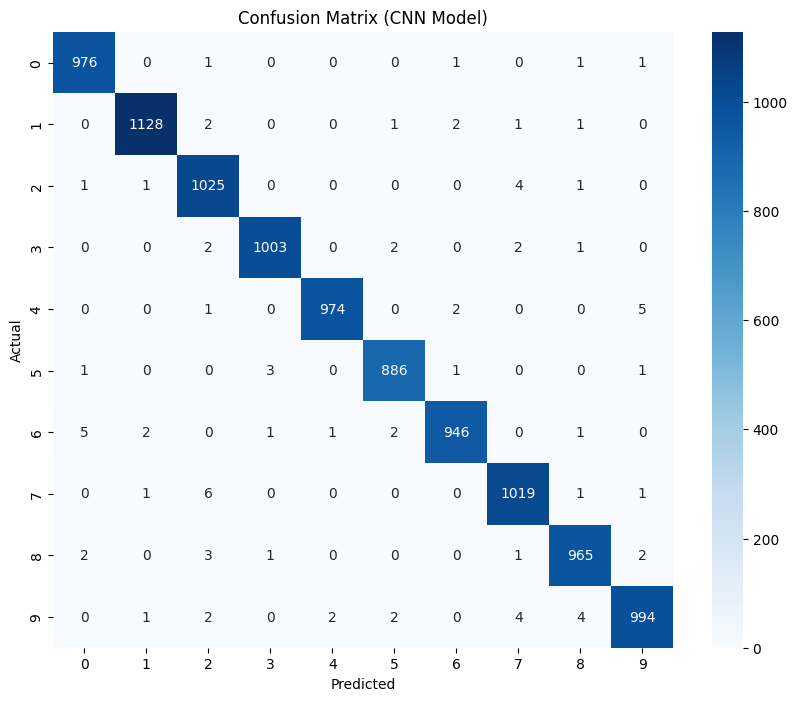


Classification Report (CNN Model):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.98      0.99      0.99      1032
           3       1.00      0.99      0.99      1010
           4       1.00      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [33]:
all_predicted = []
all_labels = []
model.eval() # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in test_loader:
        # Add a channel dimension for CNN input (batch_size, 1, height, width)
        images = images.unsqueeze(1)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_predicted)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (CNN Model)')
plt.show()

# Display classification report
print("\nClassification Report (CNN Model):")
print(classification_report(all_labels, all_predicted))

Kolejne 10 epok, i troszke lepsza dokładność. Mógłbym trenować dalej i zobaczyć co się stanie, jednak to trenowanie zajmuje trochę czasu, a mnie trochę czas goni, dlatego na tym etapie zakończę. Na zakończenie:
1. Można by spróbować inne architektury sieci, inne hiperparametry, jak dropout czy liczba filtrów.
2. Dla danych mnist nasz model radzi sobie super, ale dla realnych danych warto by było zrobić jakąś augmentację. Przykładowo, wszystkie cyfry są w jednej pozycji, można by je poobracać czy dodać szumy
3. Zaskakujące jest dla mnie to że można mieć lepsze accuracy przy wyższej wartości loss, nie wiedziałem że tak może się zdarzyć